#                                  Project Work:Tweet disaster classification

>Twitter has become an important communication channel in times of emergency.
The iniquitousness of smartphones enables people to announce an emergency they are observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e., disaster relief organizations and news agencies).
In fact, this project is addressing this issue by building a classification model to predict disaster based on tweets. Classification refers to a predictive modelling problem where a class label is predicted for a given example of input data. In the next sections, we are going to visualize the data and provide an algorithm plus an evaluation metrics.


In [ ]:
pip install -q tensorflow-text      # preprocessing text

     |████████████████████████████████| 3.4MB 5.5MB/s 


In [ ]:
#pip install -q pyyaml h5py

In [ ]:
pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 5.6MB/s 
     |████████████████████████████████| 1.2MB 15.8MB/s 
     |████████████████████████████████| 358kB 33.2MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 174kB 40.8MB/s 
     |████████████████████████████████| 645kB 32.0MB/s 


### Import Required dependencies

In [ ]:
import pandas as pd
import re
import tensorflow as tf
import shutil
import os
import numpy as np
from official.nlp import optimization
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras import layers, Model
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#from sklearn.model_selection import train_test_split
import tensorflow_hub as hub         # Pre-trained models retreival
import tensorflow_text as text # the library can perform the preprocessing regularly required by text-based models


from wordcloud import WordCloud, STOPWORDS  # Display Wordcloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
tf.random.set_seed(1234) # Set seed for reproducibilty

### Define a plot function to show model performance

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Read train and test samples

In [ ]:
train_path = "train.csv"
test_path = "train.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### Show sample of training set

In [ ]:
train.head()
#train.tail()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.describe()  #  number of samples in train and test set are equals
#test.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### Display the target class distribution

In [ ]:
# class distribution
class_distribution = train.groupby("target").count()
class_distribution

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


### Barplot of target class distribution

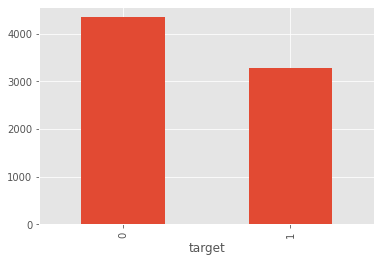

In [ ]:
class_distribution.text.plot.bar()

### Pre-processing step

In [ ]:
def remove_urls(text):
    #text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #return text
    b = re.compile(r'https?://\S+|www\.\S+')
    return b.sub(r'',text)


In [ ]:
# Here we are cleaning the data to be processed
from functools import reduce
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')

#Removing Non-English Words
try:
    STOPWORDS = set(stopwords.words('english')) 
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text):
    
    #Converting All Text to Lower Case Characters

    return text.lower()

def replace_special_characters(text):

    # Replaces Special Characters like Ampersand , Parenthesis , etc with Spacing Character    

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text):
  
   # Removes any Special Special Characters that is not a Good Symbol under Regular Expression 

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text):

    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def remove_extra_spaces(text):

   # Removes Unwanted Spacing Character's (Left and Right) from the Text 
   
    return re.sub('\s',' ',text)

def strip_text(text):

   #Removes both the leading and the trailing characters based on the string argument passed.

    return text.strip()

def remove_starting_index(text):

  #Removes Unwanted Numbers from the Starting Index.
    
    return re.sub('^[0-9]+\t', '', text)

def remove_pronunciation(text):

  #Removes Unwanted Text (Pronunciation's) when it comes between LSB and RSB.
    
    return re.sub('-LSB- .* -RSB- ', '', text)

NLTK_SYM = re.compile('\-[A-Z]{3}\-')

def remove_NLTK_sym(text):
   
  #Removes NLTK special tokens, eg. LRB (Left Round Bracket) and RRB (Right Round Brackets) .

    return NLTK_SYM.sub('', text)

def remove_tabs(text):
   
   #Removes Unwanted Tab Character in Text 
   
    return re.sub('\t',' ', text)

def flatten(L):
  res = []
  for x in L:
    if isinstance(x, list):
      res += flatten(x)
    else:
      res.append(x)
  return res

def Token(txt):
  return [line.split() for line in txt]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
PREPROCESSING_PIPELINE = [
                          remove_starting_index,
                          remove_pronunciation,
                          remove_NLTK_sym,
                          lower,
                          replace_special_characters,
                          remove_extra_spaces,
                          remove_tabs,
                          strip_text,
                          remove_urls
                          ]


#Using Anchor method to Filter the Text using the pre-processing pipeline sequence as given above

def text_prepare(text, reduce_methods=None):
    
    reduce_methods = reduce_methods if reduce_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), reduce_methods, text)


In [ ]:
# Pre-processing

print('Pre-processing the Evidence...')
# Replace each sentence with its pre-processed version
train['text']=train['text'].apply(lambda txt: text_prepare(txt))
test['text'] = test['text'].apply(lambda x : remove_urls(x))

train['text'].head()
#test['text'].head()

Pre-processing the Evidence...


0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13 000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [ ]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,aria_ahrary thetawniest the out of control wi...,1
7610,10871,NaN,NaN,m1.94 01:04 utc ?5km s of volcano hawaii. htt...,1
7611,10872,NaN,NaN,police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,the latest: more homes razed by northern calif...,1


### Display wordcloud with high frequency

positive


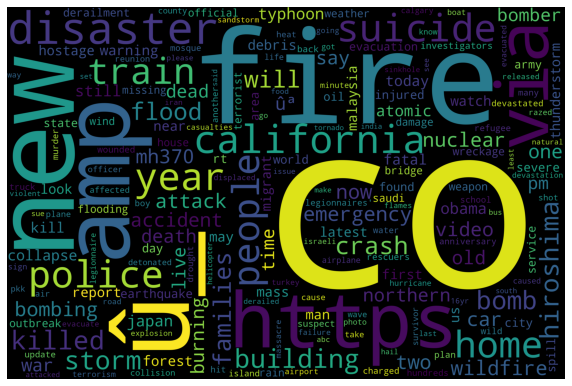

negative


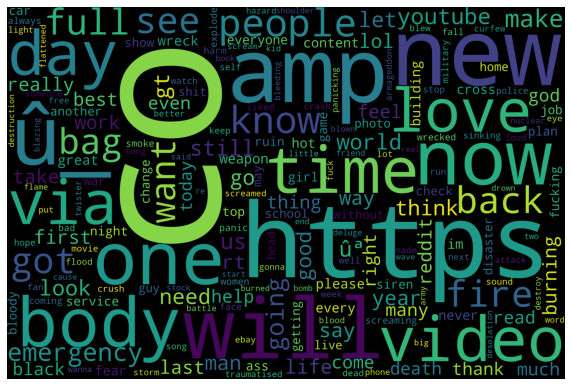

In [ ]:
from wordcloud import WordCloud, STOPWORDS

target_one_corpus = train.loc[train['target']==1]
target_one_corpus = target_one_corpus['text']



target_zero_corpus = train.loc[train['target']==0]
target_zero_corpus = target_zero_corpus['text']

print('Disaster')
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(target_one_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()


print('no disaster')
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(target_zero_corpus))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1) 
plt.axis("off");
plt.show()


### Most Frequent Words in the corporas

In [ ]:
flt_txt = flatten(Token(train['text']))


In [ ]:
from collections import Counter
cnt = Counter()
for w in flt_txt:
  cnt[w] +=1

In [ ]:
most_comon_words = cnt.most_common(20)

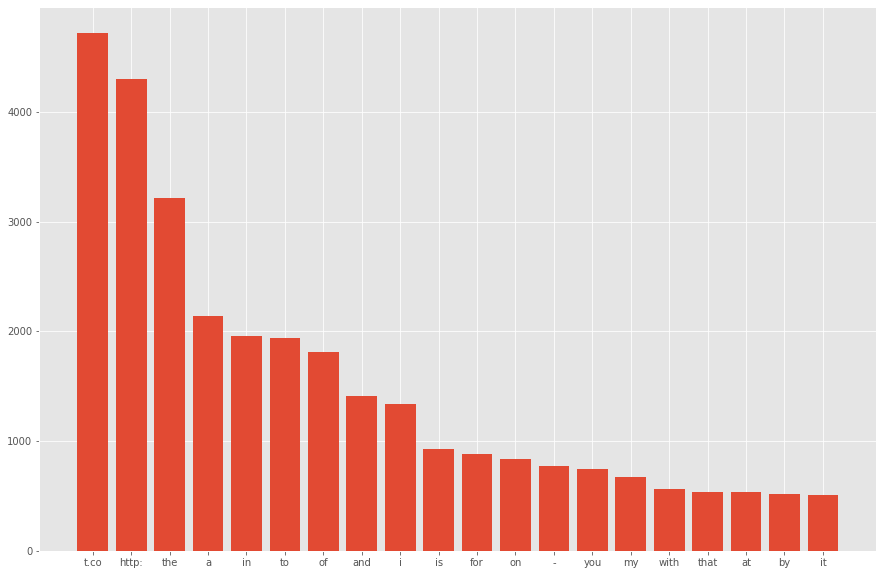

<Figure size 432x288 with 0 Axes>

In [ ]:
words = [w[0] for w in most_comon_words]
counts = [w[1] for w in most_comon_words]
plt.figure(figsize=(15,10))
plt.bar(words, counts)
plt.show()
plt.savefig('Most_Common_words.png')

### Prepare train and test set



```
# This is formatted as code
data = [[x,y] for x, y in zip(train['text'],list(train['target']))]
X_train0 = np.array([x[0] for x in data if x[0]!=''])
y_train0 = np.array([x[1] for x in data if x[0]!=''])
```



In [ ]:
# Train set

X_train = train['text'].to_numpy()
y_train = train['target'].to_numpy()

# test set
#x_test = test['text']
X_test = test['text'].to_numpy()
y_test = test['target'].to_numpy()

print(f"Train set shape: {X_train.shape}")
print(f"Length of train class label: {y_train.shape[0]}")
print("="*40)
print(f"Test set shape: {X_test.shape}")
print(f"Length of test class label: {y_test.shape[0]}")

Train set shape: (7613,)
Length of train class label: 7613
Test set shape: (7613,)
Length of test class label: 7613


In [ ]:
batch_size = 64
epochs = 150
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### BERT: Bidirectional Encoder Representations from Transformers
>

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
#tf.keras.utils.plot_model(classifier_model)

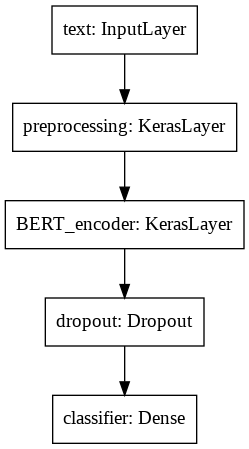

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### Set the loss and the optimizer

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
steps_per_epoch = 128
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss='binary_crossentropy',
                         metrics=metrics)

### Training

In [ ]:
%%time
# Fit the model using the train and test datasets.
history = classifier_model.fit(X_train, y_train, 
                               validation_split=0.1, epochs=epochs, callbacks=[callbacks])

Epoch 1/150
215/215 [==============================] - 221s 956ms/step - loss: 0.6634 - binary_accuracy: 0.5991 - val_loss: 0.4743 - val_binary_accuracy: 0.7769
Epoch 2/150
215/215 [==============================] - 205s 954ms/step - loss: 0.4475 - binary_accuracy: 0.8069 - val_loss: 0.3928 - val_binary_accuracy: 0.8294
Epoch 3/150
215/215 [==============================] - 205s 955ms/step - loss: 0.3813 - binary_accuracy: 0.8424 - val_loss: 0.3825 - val_binary_accuracy: 0.8320
Epoch 4/150
215/215 [==============================] - 205s 953ms/step - loss: 0.3299 - binary_accuracy: 0.8707 - val_loss: 0.4519 - val_binary_accuracy: 0.8294
Epoch 5/150
215/215 [==============================] - 205s 952ms/step - loss: 0.2564 - binary_accuracy: 0.9046 - val_loss: 0.4105 - val_binary_accuracy: 0.8255
Epoch 6/150
215/215 [==============================] - 205s 953ms/step - loss: 0.2297 - binary_accuracy: 0.9170 - val_loss: 0.4860 - val_binary_accuracy: 0.8307
Epoch 7/150
215/215 [=============

### Show performance of the model

(0.0, 0.7806146882474423)

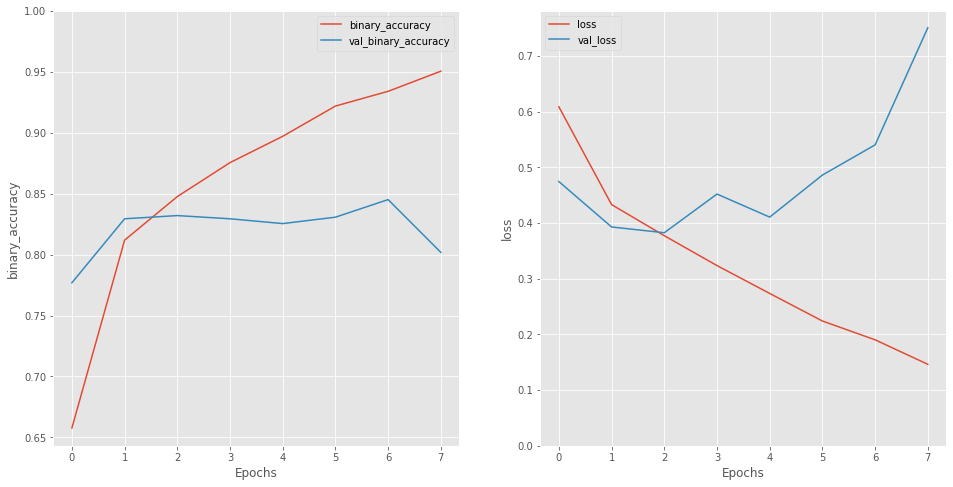

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'binary_accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

### Prediction test set

In [ ]:
y_pred_prob = classifier_model.predict(X_test)


In [ ]:
y_pred = np.array(list(map(lambda x: 1 if x>0.5 else 0, y_pred_prob.flatten())))

In [ ]:
print(f"Sample of the labels prediction {y_pred[:10]}")
print(f"Sample of the test labels {y_test[:10]}")

Sample of the labels prediction [1 1 1 1 1 1 1 1 1 1]
Sample of the test labels [1 1 1 1 1 1 1 1 1 1]


### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))
print('='*40)
print(f"f1 score on test set: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4342
           1       0.92      0.79      0.85      3271

    accuracy                           0.88      7613
   macro avg       0.89      0.87      0.87      7613
weighted avg       0.88      0.88      0.88      7613

f1 score on test set: 0.8731411981815467


### Evaluate the model over test set

In [ ]:
classifier_model.evaluate(X_test, y_test)

238/238 [==============================] - 81s 342ms/step - loss: 0.3098 - binary_accuracy: 0.8784


[0.3098098933696747, 0.8783659338951111]

In [ ]:
path = os.path.join(os.getcwd(), 'bert_based_model')

def delete_path(path):
  if os.path.exists(path):
    shutil.rmtree(path, ignore_errors=True)
  else:
    print('No such path')